# Analysis of HIV Treatment Effects - Full Compliance Dataset

This notebook explores the HIV treatment dataset with full compliance (where all treated patients receive the treatment and no control patients receive it). We'll:

1. Load and explore the dataset
2. Visualize key relationships and distributions
3. Apply simple statistical test to estimate the treatment effect with and without covariate
4. Estimate the causal structure and use this to estimate the effect
5. Compare the different estimates to the true effect

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dowhy import CausalModel
import warnings

In [2]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [10, 6]
warnings.filterwarnings('ignore')

## 1. Load and Explore the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('data/hiv_full_compliance.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (500, 10)


,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect
0,167954.626034,10501.935448,5.796889,45.167944,56482.278557,26.986300,0,0,45.652792,1.209521
1,168128.658824,10442.290575,5.830478,45.167950,56159.568003,26.986807,1,1,46.853741,1.199112
2,167038.572987,10909.257737,5.578830,45.174406,58681.818097,27.136586,0,0,45.640117,1.271628
3,168414.338928,10345.715780,5.885718,45.168128,55637.116811,26.867263,1,1,46.839835,1.182228
4,166508.684415,11253.082931,5.408287,45.185355,60534.595758,27.035632,1,1,46.945300,1.315851


In [4]:
# Summary statistics
df.describe()

,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,168063.926467,10627.670140,5.735983,45.179607,57153.976584,26.786181,0.508000,0.508000,46.264737,1.215044
std,839.015891,354.337150,0.181344,0.020141,1908.086674,0.642334,0.500437,0.500437,0.607981,0.049414
min,166036.780817,10190.290638,4.863209,45.167244,54732.749460,24.528714,0.000000,0.000000,45.600373,1.041036
25%,167532.345699,10392.108218,5.652720,45.168226,55883.158083,26.515780,0.000000,0.000000,45.651780,1.182422
50%,168090.501764,10519.724923,5.787938,45.169481,56575.382211,26.890728,1.000000,1.000000,46.753162,1.205438
75%,168461.292596,10780.730353,5.860381,45.181854,57963.435314,27.233465,1.000000,1.000000,46.857295,1.240426
max,172370.098470,12544.422161,5.997875,45.283914,67433.899989,27.706166,1.000000,1.000000,46.972498,1.379357


In [5]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


uninfected_t1      0
infected_t1        0
uninfected_t2      0
infected_t2        0
free_virus         0
immune_response    0
enrolled           0
treatment          0
outcome            0
true_effect        0
dtype: int64

In [6]:
# Treatment distribution
print(f"Treatment percentage: {df['treatment'].mean() * 100:.1f}%")

Treatment percentage: 50.8%


## 2. Visualize Key Relationships

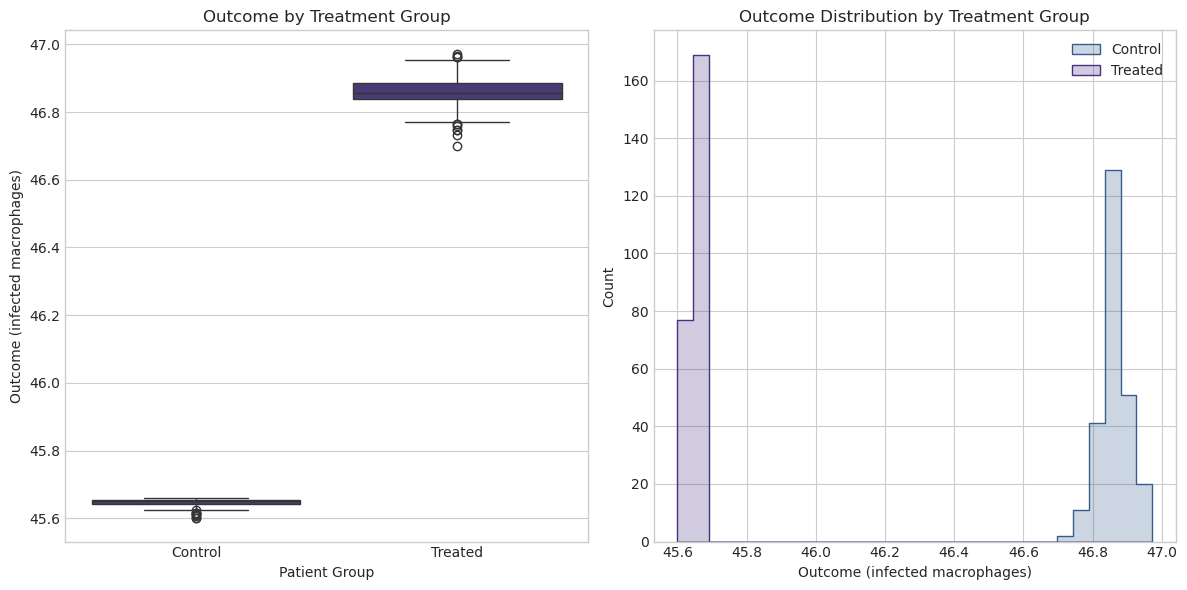

In [7]:
# Outcome distribution by treatment group
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='treatment', y='outcome', data=df)
plt.xticks([0, 1], ['Control', 'Treated'])
plt.title('Outcome by Treatment Group')
plt.xlabel('Patient Group')
plt.ylabel('Outcome (infected macrophages)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='outcome', hue='treatment', element='step', common_norm=False, bins=30)
plt.title('Outcome Distribution by Treatment Group')
plt.xlabel('Outcome (infected macrophages)')
plt.legend(['Control', 'Treated'])

plt.tight_layout()
plt.show()

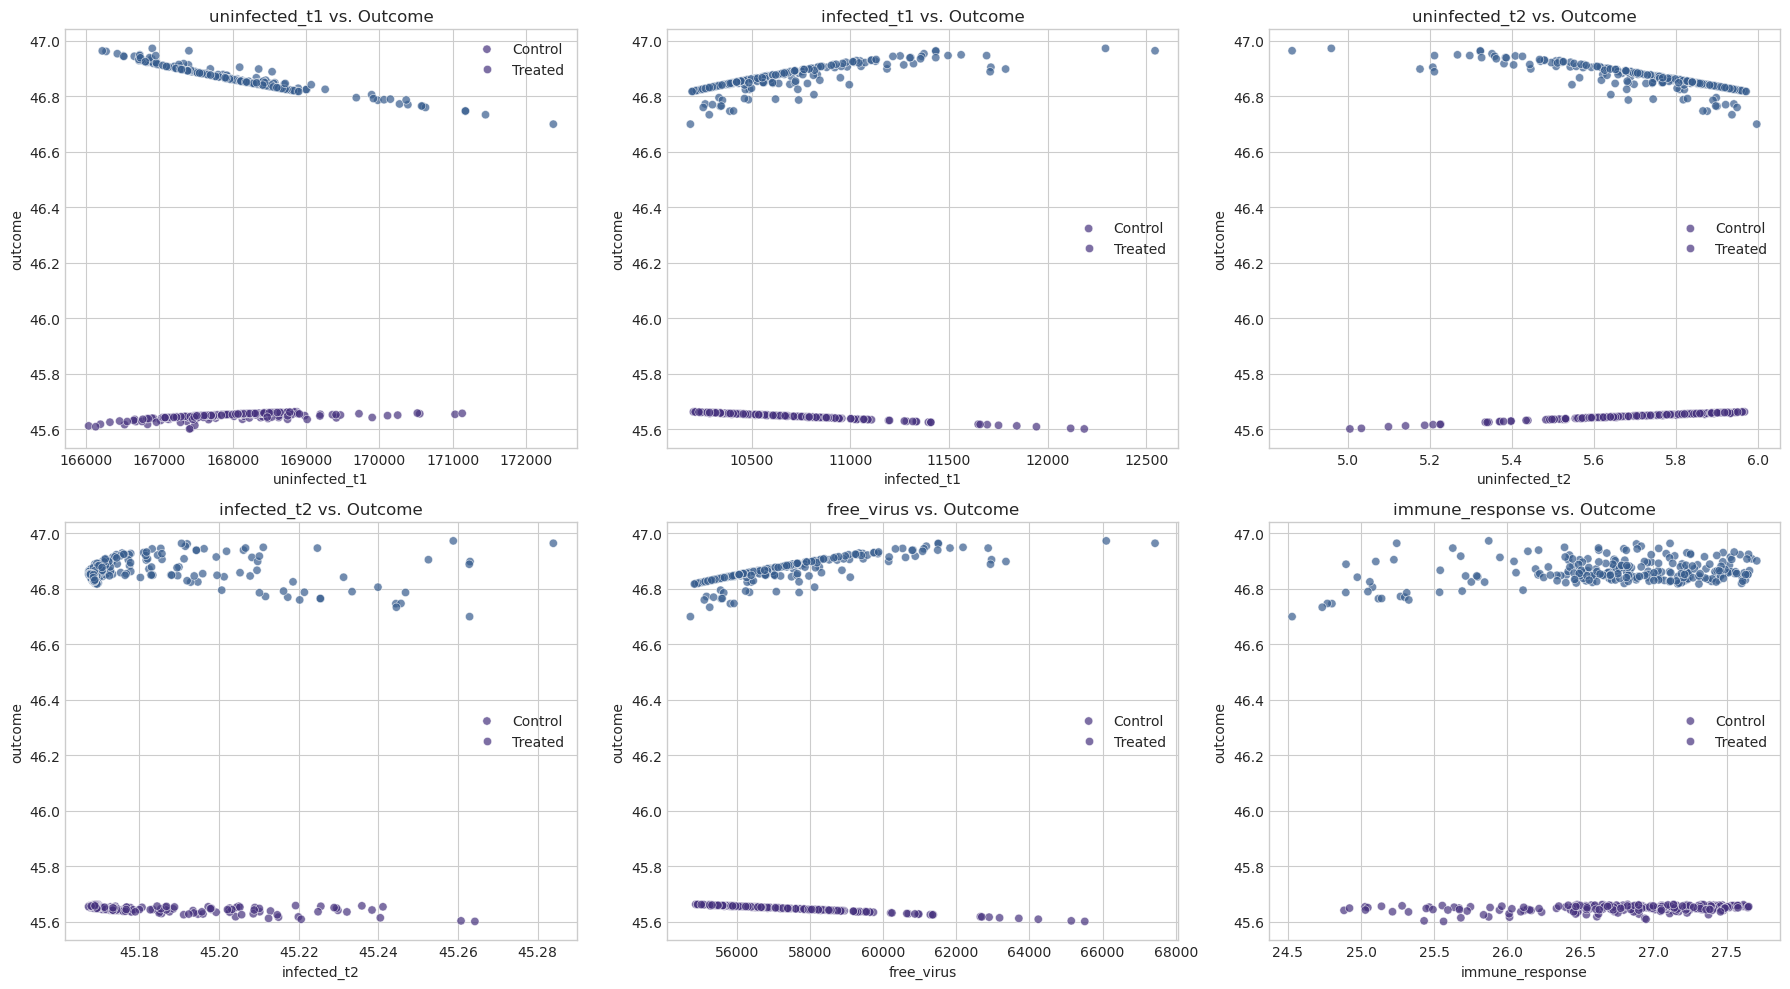

In [8]:
# Relationship between key covariates and outcome
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

covariates = ['uninfected_t1', 'infected_t1', 'uninfected_t2',
              'infected_t2', 'free_virus', 'immune_response']

for i, covariate in enumerate(covariates):
    sns.scatterplot(x=covariate, y='outcome', hue='treatment', data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{covariate} vs. Outcome')
    axes[i].legend(['Control', 'Treated'])

plt.tight_layout()
plt.show()

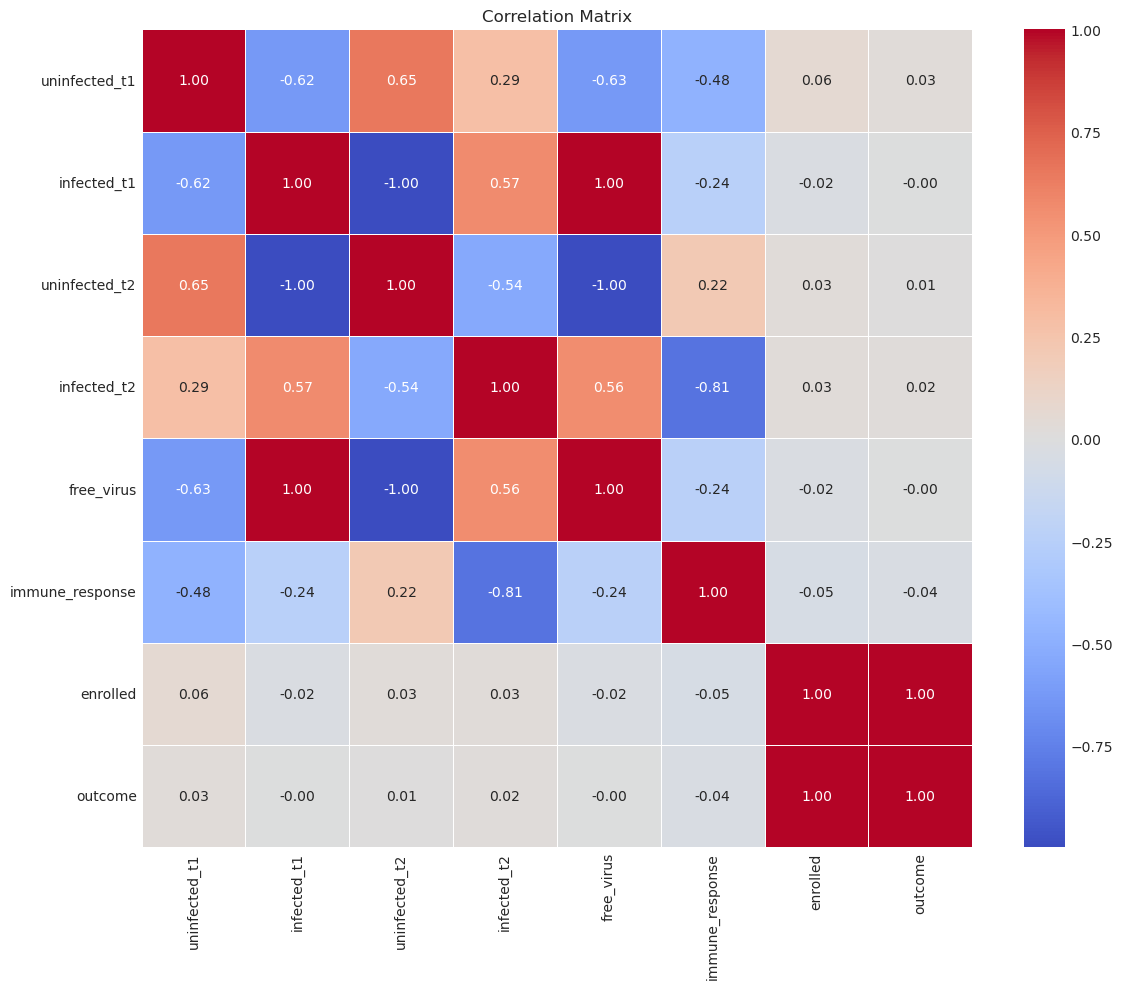

In [9]:
# Correlation matrix of covariates
correlation_vars = covariates + ['enrolled', 'outcome']
corr_matrix = df[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Estimate Treatment Effects with Simple Models

We'll start with simple statistical approaches before using causal inference methods.

In [10]:
# Calculate the true average treatment effect
true_ate = df[df['treatment'] == 1]['true_effect'].mean()

print(f"True ATE: {true_ate:.4f}")

True ATE: 1.2128


In [11]:
# Method 1: calculate the ATE directly from group means
treated_mean = df[df['treatment'] == 1]['outcome'].mean()
control_mean = df[df['treatment'] == 0]['outcome'].mean()
naive_ate = treated_mean - control_mean

print(f"Naive ATE (direct calculation): {naive_ate:.4f}")

Naive ATE (direct calculation): 1.2133


In [12]:
# Method 2: Linear regression without covariates
linear_model = sm.OLS(df['outcome'], sm.add_constant(df['treatment'])).fit()
print("Linear Regression Results (without covariates):")
print(linear_model.summary().tables[1])

Linear Regression Results (without covariates):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6484      0.002   2.31e+04      0.000      45.644      45.652
treatment      1.2133      0.003    437.992      0.000       1.208       1.219


In [13]:
# Method 3: Linear regression with covariates (adjustment)
formula = 'outcome ~ treatment + ' + ' + '.join(covariates)
linear_model_with_covariates = smf.ols(formula, data=df).fit()
print("Linear Regression Results (with covariate adjustment):")
print(linear_model_with_covariates.summary().tables[1])

Linear Regression Results (with covariate adjustment):
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         210.0758    396.284      0.530      0.596    -568.541     988.693
treatment           1.2158      0.002    555.950      0.000       1.211       1.220
uninfected_t1    5.008e-06      0.001      0.009      0.993      -0.001       0.001
infected_t1         0.0190      0.078      0.245      0.806      -0.133       0.171
uninfected_t2      -0.3188      1.482     -0.215      0.830      -3.231       2.593
infected_t2        -3.6215     10.693     -0.339      0.735     -24.631      17.388
free_virus         -0.0035      0.014     -0.244      0.807      -0.032       0.025
immune_response    -0.0016      0.009     -0.185      0.853      -0.019       0.015


## 4. Causal Inference with DoWhy

Now let's use the DoWhy package from PyWhy to estimate the causal effect using more sophisticated methods.

In [14]:
# Define the causal model
# The graph structure assumes treatment is assigned based on instrument (study enrollment)
# and that covariates affect the outcome
graph = '''
    digraph {
        treatment -> outcome;
        enrolled -> treatment;
        uninfected_t1 -> outcome;
        infected_t1 -> outcome;
        uninfected_t2 -> outcome;
        infected_t2 -> outcome;
        free_virus -> outcome;
        immune_response -> outcome;
    }
'''

causal_model = CausalModel(
    data=df,
    treatment='treatment',
    outcome='outcome',
    graph=graph,
    instruments=['instrument']
)

In [15]:
# Identify causal effect (backdoor and IV methods)
identified_estimand_backdoor = causal_model.identify_effect(proceed_when_unidentifiable=True)
print("Identified estimand (backdoor):\n", identified_estimand_backdoor)

Identified estimand (backdoor):
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                  
────────────(E[outcome])
d[treatment]            
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,,U) = P(outcome|treatment,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                               -1⎤
 ⎢     d               ⎛     d                  ⎞  ⎥
E⎢───────────(outcome)⋅⎜───────────([treatment])⎟  ⎥
 ⎣d[enrolled]          ⎝d[enrolled]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→outcome then ¬(U →→{enrolled})
Estimand assumption 2, Exclusion: If we remove {enrolled}→{treatment}, then ¬({enrolled}→outcome)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [16]:
# Estimate causal effect using backdoor adjustment
estimate_backdoor = causal_model.estimate_effect(
    identified_estimand_backdoor,
    method_name="backdoor.linear_regression",
    target_units="ate"
)

print("Backdoor estimate (linear regression with covariate adjustment):")
print(estimate_backdoor)

Backdoor estimate (linear regression with covariate adjustment):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                  
────────────(E[outcome])
d[treatment]            
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,,U) = P(outcome|treatment,)

## Realized estimand
b: outcome~treatment+treatment*infected_t1+treatment*uninfected_t2+treatment*infected_t2+treatment*immune_response+treatment*free_virus+treatment*uninfected_t1
Target units: 

## Estimate
Mean value: 1.215312848424439
### Conditional Estimates
__categorical__infected_t1       __categorical__uninfected_t2  __categorical__infected_t2    __categorical__immune_response  __categorical__free_virus       __categorical__uninfected_t1
(10190.289999999999, 10352.207]  (5.815, 5.884]                (45.168, 45.169]              (26.754, 27.049]                (

## 5. Compare Estimated vs True Treatment Effects

In [17]:
# Compare all the estimation methods
methods = [
    "Naive Difference in Means",
    "Linear Regression (without covariates)",
    "Linear Regression (with covariates)",
    "DoWhy Backdoor Adjustment",
]

estimates = [
    naive_ate,
    linear_model.params['treatment'],
    linear_model_with_covariates.params['treatment'],
    float(estimate_backdoor.value),
]

results_df = pd.DataFrame({
    'Method': methods,
    'Estimated Effect': estimates,
    'Bias': [est - true_ate for est in estimates]
})

print(results_df)

                                   Method  Estimated Effect      Bias
0               Naive Difference in Means          1.213327  0.000497
1  Linear Regression (without covariates)          1.213327  0.000497
2     Linear Regression (with covariates)          1.215792  0.002962
3               DoWhy Backdoor Adjustment          1.215313  0.002483


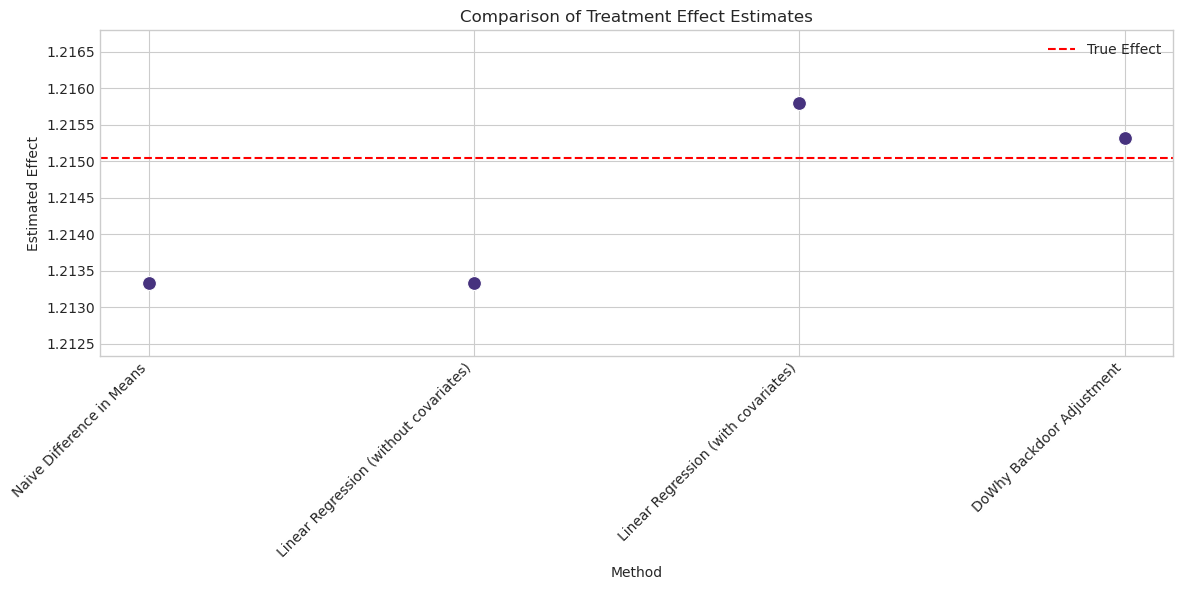

In [113]:
# Visualize the estimated vs true effects using scatter plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x='Method', y='Estimated Effect', data=results_df, s=100)
plt.axhline(y=true_ate, color='r', linestyle='--', label='True Effect')
plt.legend()
plt.title('Comparison of Treatment Effect Estimates')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['Estimated Effect'].min() - 0.001, results_df['Estimated Effect'].max() + 0.001)  # Adjust y-axis limits
plt.tight_layout()
plt.show()

## 6. Conclusions

In this analysis, we explored the HIV treatment dataset with full compliance and estimated the causal effect of treatment using various methods:

1. **Naive approach**: Simple difference in means between treatment and control groups
2. **Simple regression**: Linear regression with treatment as the only predictor is equivalent to difference in means
3. **Covariate adjustment**: Linear regression controlling for observed covariates improves the estimate even when the experiment system is perfect
4. **Backdoor adjustment**: DoWhy's implementation of the backdoor criterion for causal estimation brings the estimate even closer by incorporating causal assumptions

Key findings:
- With full compliance, the naive approach provides a perfectly good estimate, but even here it can be improved upon
- Covariate adjustment improves estimation slightly by accounting for the effect of covariates on the outcome
- Causal assumptions improve further on the covariate adjust as they bring in more information in the those assumptions

Even in the case of flawlessly run experiment, using more complex inference methods can give us a better estimate. The experimental setup ensures that we don't have bias, but we can lower the variance with statistical methods